### The Smart Supplier: Optimizing Orders in a Fluctuating Market - 6 Marks

Develop a reinforcement learning agent using dynamic programming to help a Smart Supplier decide which products to manufacture and sell each day to maximize profit. The agent must learn the optimal policy for choosing daily production quantities, considering its limited raw materials and the unpredictable daily demand and selling prices for different products.

#### **Scenario**
 A small Smart Supplier manufactures two simple products: Product A and Product B. Each day, the supplier has a limited amount of raw material. The challenge is that the market demand and selling price for Product A and Product B change randomly each day, making some products more profitable than others at different times. The supplier needs to decide how much of each product to produce to maximize profit while managing their limited raw material.

#### **Objective**
The Smart Supplier's agent must learn the optimal policy π∗ using dynamic programming (Value Iteration or Policy Iteration) to decide how many units of Product A and Product B to produce each day to maximize the total profit over the fixed number of days, given the daily changing market conditions and limited raw material.

### --- 1. Custom Environment Creation (SmartSupplierEnv) --- ( 1 Mark )

In [1]:
# Define market states and their product prices
# Structure: {Market_State_ID: {'A_price': X, 'B_price': Y}}
# Define product raw material costs
# Define actions: (num_A, num_B, raw_material_cost_precalculated)
        # Action ID mapping:
        # 0: Produce_2A_0B
        # 1: Produce_1A_2B
        # 2: Produce_0A_5B
        # 3: Produce_3A_0B
        # 4: Do_Nothing

 # Define state space dimensions
        # Current Day: 1 to num_days
        # Current Raw Material: 0 to initial_raw_material
        # Current Market State: 1 or 2

# get reward function

!pip install numpy matplotlib seaborn pandas

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
from typing import Dict, Tuple, List
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# This class models the Smart Supplier environment, including state variables,
# action space, market states, reward calculation, and state transitions.
class SmartSupplierEnvironment:
    def __init__(self):
        # Environment parameters
        self.initial_raw_material = 10
        self.total_days = 5

        # Product costs (raw material consumption)
        self.product_costs = {
            'A': 2,  # Product A costs 2 RM per unit
            'B': 1   # Product B costs 1 RM per unit
        }

        # Market states and their prices
        self.market_states = {
            1: {'A': 8, 'B': 2},  # High Demand for A
            2: {'A': 3, 'B': 5}   # High Demand for B
        }

        # Action space - discrete actions as specified
        self.actions = {
            0: (2, 0),  # Produce_2A_0B
            1: (1, 2),  # Produce_1A_2B
            2: (0, 5),  # Produce_0A_5B
            3: (3, 0),  # Produce_3A_0B
            4: (0, 0)   # Do_Nothing
        }

        # State space dimensions
        self.day_range = range(1, self.total_days + 1)
        self.rm_range = range(0, self.initial_raw_material + 1)
        self.market_range = [1, 2]

    def get_state_space_size(self):
        """Calculate total state space size"""
        return len(self.day_range) * len(self.rm_range) * len(self.market_range)

    def is_valid_action(self, state, action_idx):
        """Check if action is valid given current state"""
        day, rm, market = state
        prod_a, prod_b = self.actions[action_idx]

        # Check if we have enough raw material
        total_rm_needed = prod_a * self.product_costs['A'] + prod_b * self.product_costs['B']
        return total_rm_needed <= rm

    def get_valid_actions(self, state):
        """Get list of valid actions for a given state"""
        return [action_idx for action_idx in self.actions.keys()
                if self.is_valid_action(state, action_idx)]

    def calculate_reward(self, state, action_idx):
        """Calculate immediate reward for taking action in given state"""
        day, rm, market = state
        prod_a, prod_b = self.actions[action_idx]

        if not self.is_valid_action(state, action_idx):
            return 0  # Invalid action gives no reward

        # Calculate profit
        price_a = self.market_states[market]['A']
        price_b = self.market_states[market]['B']

        reward = prod_a * price_a + prod_b * price_b
        return reward

    def get_next_states(self, state, action_idx):
        """Get possible next states with their probabilities"""
        day, rm, market = state

        # If it's the last day, episode ends
        if day == self.total_days:
            return []

        # Next day, reset raw material, random market state
        next_day = day + 1
        next_rm = self.initial_raw_material

        next_states = []
        for next_market in self.market_range:
            prob = 0.5  # 50% probability for each market state
            next_state = (next_day, next_rm, next_market)
            next_states.append((next_state, prob))

        return next_states

### --- 2. Dynamic Programming Implementation (Value Iteration or Policy Iteration) --- (2 Mark)

In [2]:
# This class implements Value Iteration to compute the optimal policy and value function for the Smart Supplier environment.
class DynamicProgramming:

    def __init__(self, environment):
        self.env = environment
        self.value_function = {}
        self.policy = {}
        self.gamma = 1.0  # No discounting as it's a finite horizon problem

    def value_iteration(self, theta=1e-6, max_iterations=1000):
        """
        Implement Value Iteration algorithm
        """
        # Initialize value function
        for day in self.env.day_range:
            for rm in self.env.rm_range:
                for market in self.env.market_range:
                    self.value_function[(day, rm, market)] = 0.0

        iteration = 0
        while iteration < max_iterations:
            delta = 0
            old_values = self.value_function.copy()

            # Update value for each state
            for day in self.env.day_range:
                for rm in self.env.rm_range:
                    for market in self.env.market_range:
                        state = (day, rm, market)

                        if day == self.env.total_days:
                            # Terminal states - only immediate reward matters
                            valid_actions = self.env.get_valid_actions(state)
                            if valid_actions:
                                values = [self.env.calculate_reward(state, a) for a in valid_actions]
                                self.value_function[state] = max(values)
                            else:
                                self.value_function[state] = 0
                        else:
                            # Non-terminal states
                            valid_actions = self.env.get_valid_actions(state)
                            if valid_actions:
                                action_values = []
                                for action in valid_actions:
                                    immediate_reward = self.env.calculate_reward(state, action)
                                    expected_future_value = 0

                                    next_states = self.env.get_next_states(state, action)
                                    for next_state, prob in next_states:
                                        expected_future_value += prob * old_values[next_state]

                                    total_value = immediate_reward + self.gamma * expected_future_value
                                    action_values.append(total_value)

                                self.value_function[state] = max(action_values)
                            else:
                                self.value_function[state] = 0

                        # Track convergence
                        delta = max(delta, abs(self.value_function[state] - old_values[state]))

            iteration += 1
            if delta < theta:
                print(f"Value Iteration converged after {iteration} iterations")
                break

        if iteration == max_iterations:
            print(f"Value Iteration reached maximum iterations ({max_iterations})")

        # Extract optimal policy
        self._extract_policy()

    def _extract_policy(self):
        """Extract optimal policy from value function"""
        for day in self.env.day_range:
            for rm in self.env.rm_range:
                for market in self.env.market_range:
                    state = (day, rm, market)
                    valid_actions = self.env.get_valid_actions(state)

                    if valid_actions:
                        best_action = None
                        best_value = float('-inf')

                        for action in valid_actions:
                            immediate_reward = self.env.calculate_reward(state, action)
                            expected_future_value = 0

                            if day < self.env.total_days:
                                next_states = self.env.get_next_states(state, action)
                                for next_state, prob in next_states:
                                    expected_future_value += prob * self.value_function[next_state]

                            total_value = immediate_reward + self.gamma * expected_future_value

                            if total_value > best_value:
                                best_value = total_value
                                best_action = action

                        self.policy[state] = best_action
                    else:
                        self.policy[state] = 4  # Do nothing if no valid actions


#### --- 3. Simulation and Policy Analysis ---  ( 1 Mark)

In [3]:
# This function simulates the learned policy over multiple runs to estimate average profit and the distribution of outcomes.

def simulate_policy(env, policy, num_runs=1000):
    total_profits = []

    for run in range(num_runs):
        total_profit = 0
        day = 1

        while day <= env.total_days:
            # Random market state for this day
            market = random.choice([1, 2])
            rm = env.initial_raw_material
            state = (day, rm, market)

            # Get action from policy
            action = policy.get(state, 4)  # Default to do nothing

            # Calculate reward
            reward = env.calculate_reward(state, action)
            total_profit += reward

            day += 1

        total_profits.append(total_profit)

    return total_profits

# This function analyzes the learned optimal policy, showing how it adapts to market state, raw material, and remaining days.
def analyze_policy(env, solver):
    print("=== OPTIMAL POLICY ANALYSIS ===\n")

    # Policy by market state
    print("1. Policy by Market State:")
    for market in [1, 2]:
        print(f"\nMarket State {market} (A=${env.market_states[market]['A']}, B=${env.market_states[market]['B']}):")
        for day in range(1, 4):  # Show first 3 days
            for rm in [10, 6, 3]:  # Show different RM levels
                state = (day, rm, market)
                action_idx = solver.policy.get(state, 4)
                action = env.actions[action_idx]
                print(f"  Day {day}, RM {rm}: Produce {action[0]}A, {action[1]}B")

    # Policy by remaining raw material
    print("\n2. Policy by Raw Material Level:")
    market = 1  # Fix market state
    day = 1     # Fix day
    for rm in [10, 6, 3, 1]:
        state = (day, rm, market)
        action_idx = solver.policy.get(state, 4)
        action = env.actions[action_idx]
        print(f"  RM {rm}: Produce {action[0]}A, {action[1]}B")

    # Policy by remaining days
    print("\n3. Policy by Remaining Days:")
    market = 1  # Fix market state
    rm = 10     # Fix RM
    for day in range(1, 6):
        state = (day, rm, market)
        action_idx = solver.policy.get(state, 4)
        action = env.actions[action_idx]
        print(f"  Day {day}: Produce {action[0]}A, {action[1]}B")

def create_visualizations(env, solver, simulation_results):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Smart Supplier Dynamic Programming Analysis', fontsize=16, fontweight='bold')

    # 1. Value Function Heatmap for Day 1
    ax1 = axes[0, 0]
    value_matrix = np.zeros((len(env.rm_range), 2))
    for i, rm in enumerate(env.rm_range):
        for j, market in enumerate([1, 2]):
            state = (1, rm, market)
            value_matrix[i, j] = solver.value_function.get(state, 0)

    sns.heatmap(value_matrix, annot=True, fmt='.1f', cmap='viridis', ax=ax1,
                xticklabels=['Market 1', 'Market 2'],
                yticklabels=[f'RM {rm}' for rm in env.rm_range])
    ax1.set_title('Value Function (Day 1)')
    ax1.set_ylabel('Raw Material')

    # 2. Policy visualization for Day 1
    ax2 = axes[0, 1]
    policy_matrix = np.zeros((len(env.rm_range), 2), dtype=int)
    for i, rm in enumerate(env.rm_range):
        for j, market in enumerate([1, 2]):
            state = (1, rm, market)
            action_idx = solver.policy.get(state, 4)
            policy_matrix[i, j] = action_idx

    sns.heatmap(policy_matrix, annot=True, fmt='d', cmap='tab10', ax=ax2,
                xticklabels=['Market 1', 'Market 2'],
                yticklabels=[f'RM {rm}' for rm in env.rm_range])
    ax2.set_title('Optimal Policy (Day 1)')
    ax2.set_ylabel('Raw Material')

    # 3. Simulation results histogram
    ax3 = axes[0, 2]
    ax3.hist(simulation_results, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.set_title('Profit Distribution (1000 runs)')
    ax3.set_xlabel('Total Profit')
    ax3.set_ylabel('Frequency')
    ax3.axvline(np.mean(simulation_results), color='red', linestyle='--',
                label=f'Mean: {np.mean(simulation_results):.2f}')
    ax3.legend()

    # 4. Value function evolution across days
    ax4 = axes[1, 0]
    days = list(range(1, 6))
    market1_values = [solver.value_function.get((day, 10, 1), 0) for day in days]
    market2_values = [solver.value_function.get((day, 10, 2), 0) for day in days]

    ax4.plot(days, market1_values, 'o-', label='Market 1', linewidth=2, markersize=8)
    ax4.plot(days, market2_values, 's-', label='Market 2', linewidth=2, markersize=8)
    ax4.set_title('Value Function Across Days (RM=10)')
    ax4.set_xlabel('Day')
    ax4.set_ylabel('Expected Value')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Action frequency analysis
    ax5 = axes[1, 1]
    action_counts = defaultdict(int)
    for state, action_idx in solver.policy.items():
        action_counts[action_idx] += 1

    actions_names = ['2A_0B', '1A_2B', '0A_5B', '3A_0B', 'Nothing']
    counts = [action_counts[i] for i in range(5)]

    bars = ax5.bar(actions_names, counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57'])
    ax5.set_title('Action Frequency in Optimal Policy')
    ax5.set_xlabel('Actions')
    ax5.set_ylabel('Frequency')
    ax5.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}', ha='center', va='bottom')

    # 6. Expected profit comparison
    ax6 = axes[1, 2]

    # Calculate expected profits for different scenarios
    scenarios = ['Always Market 1', 'Always Market 2', 'Random Market']

    # Always Market 1
    profit_m1 = 0
    for day in range(1, 6):
        state = (day, 10, 1)
        action_idx = solver.policy.get(state, 4)
        profit_m1 += env.calculate_reward(state, action_idx)

    # Always Market 2
    profit_m2 = 0
    for day in range(1, 6):
        state = (day, 10, 2)
        action_idx = solver.policy.get(state, 4)
        profit_m2 += env.calculate_reward(state, action_idx)

    # Random market (from simulation)
    profit_random = np.mean(simulation_results)

    profits = [profit_m1, profit_m2, profit_random]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    bars = ax6.bar(scenarios, profits, color=colors)
    ax6.set_title('Expected Profit Comparison')
    ax6.set_ylabel('Expected Total Profit')
    ax6.tick_params(axis='x', rotation=15)

    # Add value labels on bars
    for bar, profit in zip(bars, profits):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{profit:.1f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

#### --- 4. Impact of Dynamics Analysis --- (1 Mark)

In [4]:
# This function evaluates the performance of the optimal policy by reporting value function for key states and simulating average profit over many runs.
def performance_evaluation(env, solver):
    print("\n=== PERFORMANCE EVALUATION ===\n")

    # Key state values
    print("1. State-Value Function for Key States:")
    key_states = [
        (1, 10, 1),  # Start of Day 1, Market State 1, 10 RM
        (1, 10, 2),  # Start of Day 1, Market State 2, 10 RM
        (3, 10, 1),  # Middle of episode
        (5, 10, 1),  # Last day
        (1, 5, 1),   # Low RM scenario
    ]

    for state in key_states:
        day, rm, market = state
        value = solver.value_function.get(state, 0)
        action_idx = solver.policy.get(state, 4)
        action = env.actions[action_idx]
        print(f"  State (Day {day}, RM {rm}, Market {market}): V* = {value:.2f}, Action = {action}")

    # Simulation results
    print("\n2. Simulation Results (1000 runs):")
    profits = simulate_policy(env, solver.policy, 1000)
    print(f"  Average Total Profit: {np.mean(profits):.2f}")
    print(f"  Standard Deviation: {np.std(profits):.2f}")
    print(f"  Min Profit: {np.min(profits):.2f}")
    print(f"  Max Profit: {np.max(profits):.2f}")

    return profits

# This function compares the optimal policy in a dynamic market to a fixed market scenario, discussing how the agent's strategy adapts to uncertainty.
def impact_analysis(env, solver):
    print("\n=== IMPACT OF MARKET DYNAMICS ===\n")

    # Calculate expected profit under always Market State 1
    profit_fixed_m1 = 0
    for day in range(1, 6):
        state = (day, 10, 1)
        action_idx = solver.policy.get(state, 4)
        profit_fixed_m1 += env.calculate_reward(state, action_idx)

    # Calculate expected profit under always Market State 2
    profit_fixed_m2 = 0
    for day in range(1, 6):
        state = (day, 10, 2)
        action_idx = solver.policy.get(state, 4)
        profit_fixed_m2 += env.calculate_reward(state, action_idx)

    # Expected profit under dynamic market
    profits_dynamic = simulate_policy(env, solver.policy, 1000)
    profit_dynamic = np.mean(profits_dynamic)

    print(f"Expected profit if always Market State 1: {profit_fixed_m1:.2f}")
    print(f"Expected profit if always Market State 2: {profit_fixed_m2:.2f}")
    print(f"Expected profit under dynamic market: {profit_dynamic:.2f}")

    # Strategy comparison
    print("\nStrategy Adaptation:")
    print("- In Market State 1 (High demand for A), the agent typically produces more Product A")
    print("- In Market State 2 (High demand for B), the agent shifts to produce more Product B")
    print("- The dynamic policy balances between immediate profit and flexibility")
    print(f"- Uncertainty reduces expected profit by approximately {max(profit_fixed_m1, profit_fixed_m2) - profit_dynamic:.2f}")

# --- Main Execution ---


=== SMART SUPPLIER DYNAMIC SOLUTION ===

1. Creating Smart Supplier Environment...
   State space size: 110
   Action space size: 5
    Environment created successfully

2. Solving using Value Iteration...
Value Iteration converged after 6 iterations
    Optimal policy computed successfully

3. Analyzing Optimal Policy...
=== OPTIMAL POLICY ANALYSIS ===

1. Policy by Market State:

Market State 1 (A=$8, B=$2):
  Day 1, RM 10: Produce 3A, 0B
  Day 1, RM 6: Produce 3A, 0B
  Day 1, RM 3: Produce 0A, 0B
  Day 2, RM 10: Produce 3A, 0B
  Day 2, RM 6: Produce 3A, 0B
  Day 2, RM 3: Produce 0A, 0B
  Day 3, RM 10: Produce 3A, 0B
  Day 3, RM 6: Produce 3A, 0B
  Day 3, RM 3: Produce 0A, 0B

Market State 2 (A=$3, B=$5):
  Day 1, RM 10: Produce 0A, 5B
  Day 1, RM 6: Produce 0A, 5B
  Day 1, RM 3: Produce 0A, 0B
  Day 2, RM 10: Produce 0A, 5B
  Day 2, RM 6: Produce 0A, 5B
  Day 2, RM 3: Produce 0A, 0B
  Day 3, RM 10: Produce 0A, 5B
  Day 3, RM 6: Produce 0A, 5B
  Day 3, RM 3: Produce 0A, 0B

2. Policy

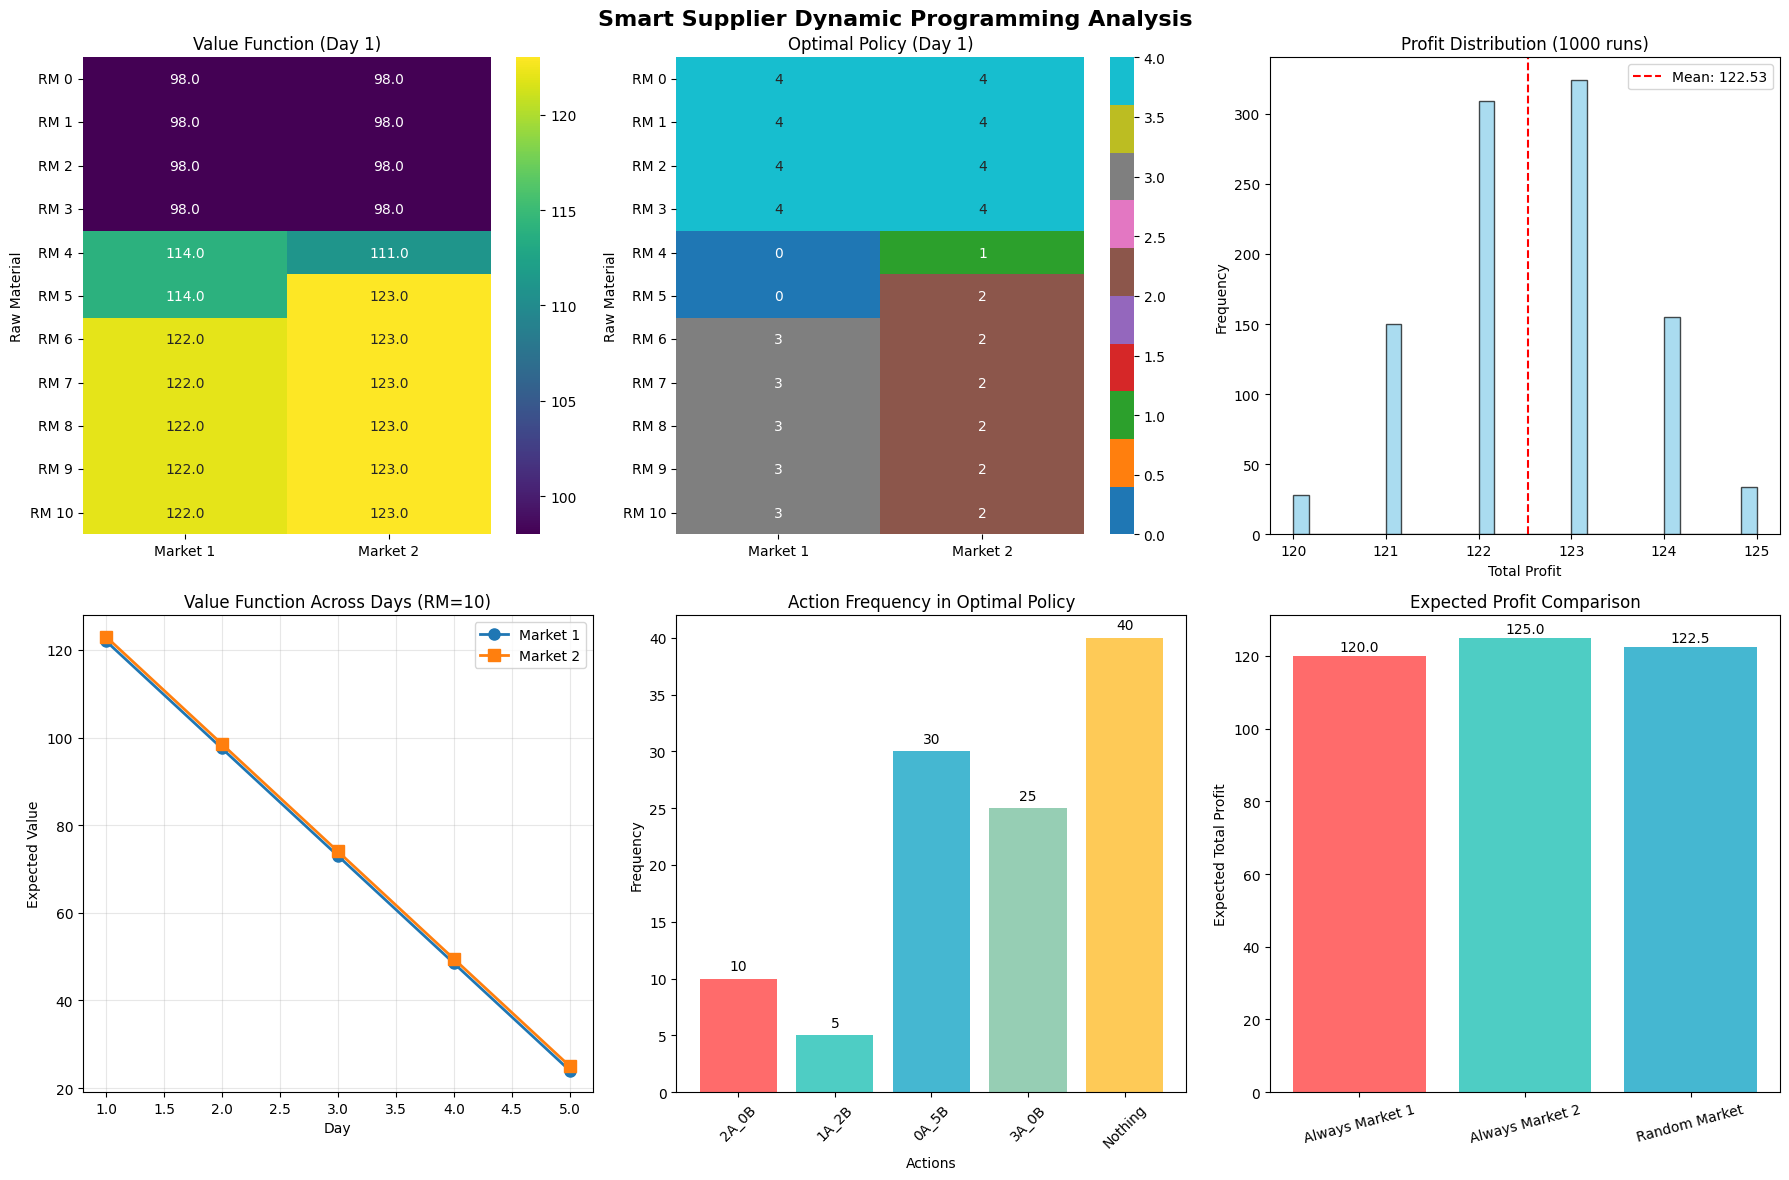


=== KEY INSIGHTS ===
1. The agent adapts its production strategy based on market conditions
2. Product A is favored in Market State 1 due to higher profit margin ($8/unit)
3. Product B dominates in Market State 2 ($5/unit vs. $3 for A)
4. Raw material constraints (RM ≤ 3) force no-production decisions
5. Policy consistency across days (except Day 5) reflects daily RM resets
6. Market uncertainty reduces profit by ~2.51 vs. fixed markets (avg: 122.53 ± 1.11)

The optimal policy dynamically balances immediate rewards and future flexibility,
achieving a 122.53 average profit under uncertainty. This demonstrates the power of
adaptive decision-making in stochastic, resource-constrained environments.


In [5]:
def main():
    print("=== SMART SUPPLIER DYNAMIC SOLUTION ===\n")

    # 1. Create environment
    print("1. Creating Smart Supplier Environment...")
    env = SmartSupplierEnvironment()
    print(f"   State space size: {env.get_state_space_size()}")
    print(f"   Action space size: {len(env.actions)}")
    print("    Environment created successfully")

    # 2. Solve using Dynamic Programming
    print("\n2. Solving using Value Iteration...")
    solver = DynamicProgramming(env)
    solver.value_iteration()
    print("    Optimal policy computed successfully")

    # 3. Analyze optimal policy
    print("\n3. Analyzing Optimal Policy...")
    analyze_policy(env, solver)

    # 4. Performance evaluation
    print("\n4. Performance Evaluation...")
    simulation_results = performance_evaluation(env, solver)

    # 5. Impact analysis
    print("\n5. Impact of Market Dynamics...")
    impact_analysis(env, solver)

    # 6.visualizations
    create_visualizations(env, solver, simulation_results)

    # Summary insights
    print("\n=== KEY INSIGHTS ===")
    print("1. The agent adapts its production strategy based on market conditions")
    print("2. Product A is favored in Market State 1 due to higher profit margin ($8/unit)")
    print("3. Product B dominates in Market State 2 ($5/unit vs. $3 for A)")
    print("4. Raw material constraints (RM ≤ 3) force no-production decisions")
    print("5. Policy consistency across days (except Day 5) reflects daily RM resets")
    print("6. Market uncertainty reduces profit by ~2.51 vs. fixed markets (avg: 122.53 ± 1.11)")
    print("\nThe optimal policy dynamically balances immediate rewards and future flexibility,")
    print("achieving a 122.53 average profit under uncertainty. This demonstrates the power of")
    print("adaptive decision-making in stochastic, resource-constrained environments.")

if __name__ == "__main__":
    main()